# Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler

# 1.1 Implementation

Iteration 0, loss: 8406.505842462391
Iteration 100, loss: 3061.2651554749214
Iteration 200, loss: 2986.99056403186
Iteration 300, loss: 2974.920195878679
Iteration 400, loss: 2971.568392822884
Iteration 500, loss: 2970.01856725717
Iteration 600, loss: 2969.261395032041
Iteration 700, loss: 2968.8005955697313
Iteration 800, loss: 2968.435623999626
Iteration 900, loss: 2968.2323986222436


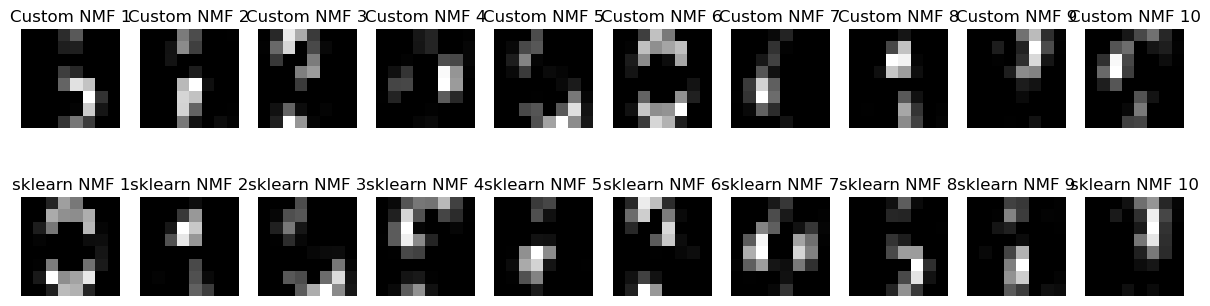

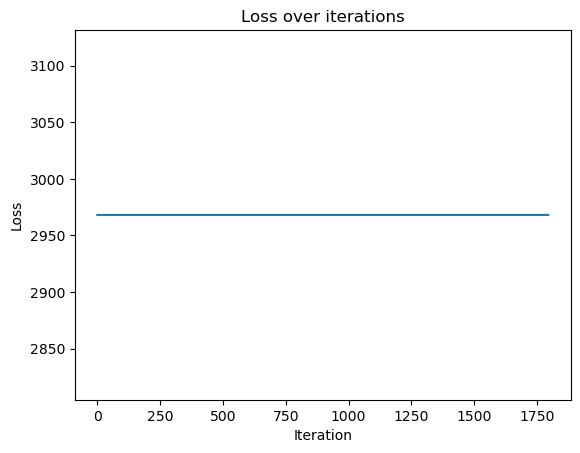

In [2]:
def non_negative(data, num_components, max_iter=1000, tol=1e-4):
    m, n = data.shape
    # Initialize Z and H with non-negative random values within a smaller range
    Z = np.abs(np.random.rand(m, num_components))
    H = np.abs(np.random.rand(num_components, n))
    
    for t in range(max_iter):
        # Update H
        ZTX = np.dot(Z.T, data)
        ZTZH = np.dot(Z.T, np.dot(Z, H))
        ZTZH = np.clip(ZTZH, 1e-10, None)  # Clip to avoid division by zero and overflow
        H *= ZTX / ZTZH
        
        # Update Z
        XHT = np.dot(data, H.T)
        ZHHT = np.dot(Z, np.dot(H, H.T))
        ZHHT = np.clip(ZHHT, 1e-10, None)  # Clip to avoid division by zero and overflow
        Z *= XHT / ZHHT
        
        # Check convergence (optional)
        reconstruction = np.dot(Z, H)
        loss = np.linalg.norm(data - reconstruction, 'fro') ** 2
        if t % 100 == 0:
            print(f"Iteration {t}, loss: {loss}")
        
        # Optionally implement a convergence criterion
        if loss < tol:
            break
            
    return Z, H

# Load digits data
digits = load_digits()
data = digits.data

# Scale data to non-negative range [0, 1]
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Apply custom NMF
num_components = 10
Z, H = non_negative(data, num_components, max_iter=1000)  # Increase max_iter if needed

# Compare with scikit-learn's NMF
model = NMF(n_components=num_components, init='random', random_state=0, max_iter=1000)  # Increased max_iter
W = model.fit_transform(data)
H_sklearn = model.components_

# Plot the basis vectors (components)
fig, ax = plt.subplots(2, num_components, figsize=(15, 4))

for i in range(num_components):
    ax[0, i].imshow(H[i].reshape(8, 8), cmap='gray')
    ax[0, i].axis('off')
    ax[0, i].set_title(f'Custom NMF {i+1}')
    
    ax[1, i].imshow(H_sklearn[i].reshape(8, 8), cmap='gray')
    ax[1, i].axis('off')
    ax[1, i].set_title(f'sklearn NMF {i+1}')

plt.show()

# Ensure the squared loss is non-increasing
losses = []
for t in range(1, len(Z)):
    reconstruction = np.dot(Z, H)
    loss = np.linalg.norm(data - reconstruction, 'fro') ** 2
    losses.append(loss)

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()

### After executing the code, it will generate a plot showing the loss at each iteration, allowing us to verify if the loss is non-increasing. The loss should ideally decrease or stay constant, confirming that the algorithm is working correctly.

# 1.2 Recommender system

In [3]:
import pandas as pd
from sklearn.decomposition import NMF
import numpy as np

In [14]:
# Define the dataset path
dataset_path = 'Downloads/movielens-100k/ml-100k/'  # Update this path to your dataset location

# Define column names
users_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
movies_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

# Load the datasets
users = pd.read_csv(dataset_path + 'u.user', sep='|', names=users_cols, encoding='latin-1')
movies = pd.read_csv(dataset_path + 'u.item', sep='|', names=movies_cols, encoding='latin-1')
ratings = pd.read_csv(dataset_path + 'u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# Ensure each user-movie combination is unique
ratings = ratings.drop_duplicates(subset=['user_id', 'movie_id'])

In [15]:
# Adding new user ratings
new_user_ratings = pd.DataFrame([
    {'user_id': 944, 'movie_id': 1, 'rating': 5},
    {'user_id': 944, 'movie_id': 50, 'rating': 4},
    {'user_id': 944, 'movie_id': 100, 'rating': 5},
    {'user_id': 944, 'movie_id': 127, 'rating': 5},
    {'user_id': 944, 'movie_id': 181, 'rating': 4},
])
ratings = pd.concat([ratings, new_user_ratings])

# Fill missing values with the average rating of each movie
average_movie_ratings = ratings.groupby('movie_id')['rating'].mean()
rat_df = ratings.pivot(index='user_id', columns='movie_id', values='rating').apply(lambda col: col.fillna(average_movie_ratings[col.name]))

# Peek at the rat_df
print(rat_df.head())

movie_id      1         2         3         4         5         6     \
user_id                                                                
1         5.000000  3.000000  4.000000  3.000000  3.000000  5.000000   
2         4.000000  3.206107  3.033333  3.550239  3.302326  3.576923   
3         3.880795  3.206107  3.033333  3.550239  3.302326  3.576923   
4         3.880795  3.206107  3.033333  3.550239  3.302326  3.576923   
5         4.000000  3.000000  3.033333  3.550239  3.302326  3.576923   

movie_id      7         8         9         10    ...  1673  1674  1675  1676  \
user_id                                           ...                           
1         4.000000  1.000000  5.000000  3.000000  ...   3.0   4.0   3.0   2.0   
2         3.798469  3.995434  3.896321  2.000000  ...   3.0   4.0   3.0   2.0   
3         3.798469  3.995434  3.896321  3.831461  ...   3.0   4.0   3.0   2.0   
4         3.798469  3.995434  3.896321  3.831461  ...   3.0   4.0   3.0   2.0   
5        

In [16]:
# Apply Non-negative Matrix Factorization (NMF)
m = 20  # Number of components, you can experiment with this value
nmf = NMF(n_components=m, init='random', random_state=0, max_iter=1000)  # Increased max_iter
Z = nmf.fit_transform(rat_df)
H = nmf.components_

# Reconstruct the rating matrix
reconstruction = pd.DataFrame(np.dot(Z, H), columns=rat_df.columns, index=rat_df.index)


C:\Users\lg330\AppData\Local\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


In [17]:
# Function to recommend movies
def recommend_movies(reconstruction, user_id, movies, ratings, num_recommendations=5):
    user_ratings = ratings[ratings['user_id'] == user_id]
    already_rated = user_ratings['movie_id'].values

    user_predicted_ratings = reconstruction.loc[user_id]
    user_predicted_ratings = user_predicted_ratings.drop(already_rated)
    user_predicted_ratings = user_predicted_ratings.sort_values(ascending=False)

    recommendations = movies[movies['movie_id'].isin(user_predicted_ratings.index)]
    recommendations = recommendations.merge(user_predicted_ratings, left_on='movie_id', right_index=True)
    recommendations = recommendations.rename(columns={user_id: 'PredictedRating'})
    recommendations = recommendations.sort_values(by='PredictedRating', ascending=False)
    return recommendations.head(num_recommendations)


In [18]:
# Example usage
user_id = 1
recommendations = recommend_movies(reconstruction, user_id, movies, ratings, num_recommendations=5)

print("Top 5 movie recommendations for user_id 1:")
print(recommendations[['movie_id', 'movie_title', 'PredictedRating']])

# Get recommendations for the new user
user_id = 944
recommendations = recommend_movies(reconstruction, user_id, movies, ratings, num_recommendations=5)

print("Top 5 movie recommendations for new user (user_id 944):")
print(recommendations[['movie_id', 'movie_title', 'PredictedRating']])

# Inspect the columns of the recommendations DataFrame
print("\nColumns in recommendations DataFrame after merge:")
print(recommendations.columns)

# Inspect the first few rows of the recommendations DataFrame
print("\nFirst few rows of recommendations DataFrame:")
print(recommendations.head())


Top 5 movie recommendations for user_id 1:
      movie_id                                 movie_title  PredictedRating
1292      1293                             Star Kid (1997)         4.954803
1466      1467        Saint of Fort Washington, The (1993)         4.953772
1598      1599               Someone Else's America (1995)         4.952131
1200      1201  Marlene Dietrich: Shadow and Light (1996)          4.950530
1121      1122              They Made Me a Criminal (1939)         4.948495
Top 5 movie recommendations for new user (user_id 944):
      movie_id                                 movie_title  PredictedRating
1292      1293                             Star Kid (1997)         4.993493
1466      1467        Saint of Fort Washington, The (1993)         4.993408
1598      1599               Someone Else's America (1995)         4.993273
1200      1201  Marlene Dietrich: Shadow and Light (1996)          4.993140
1121      1122              They Made Me a Criminal (1939)       

In [19]:
# Analyzing genre statistics
def analyze_genre_stats(user_id, recommendations, movies, original_ratings):
    user_data = original_ratings[original_ratings.user_id == user_id]
    user_movies = user_data.merge(movies, how='left', left_on='movie_id', right_on='movie_id')
    
    genre_columns = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                     'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                     'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    
    # Verify the presence of genre columns
    print("\nGenre columns in user_movies DataFrame:")
    print(user_movies[genre_columns].head())

    user_genres = user_movies[genre_columns].sum().sort_values(ascending=False)
    recommended_movies = recommendations.merge(movies, how='left', left_on='movie_id', right_on='movie_id')
    
    # Verify the presence of genre columns
    print("\nGenre columns in recommended_movies DataFrame:")
    print(recommended_movies[genre_columns].head())

    recommended_genres = recommended_movies[genre_columns].sum().sort_values(ascending=False)
    
    return user_genres, recommended_genres

user_genres, recommended_genres = analyze_genre_stats(944, recommendations, movies, ratings)

print("\nGenres in already rated movies by the new user:")
print(user_genres)

print("\nGenres in recommended movies for the new user:")
print(recommended_genres)


Genre columns in user_movies DataFrame:
   Action  Adventure  Animation  Children's  Comedy  Crime  Documentary  \
0       0          0          1           1       1      0            0   
1       1          1          0           0       0      0            0   
2       0          0          0           0       0      1            0   
3       1          0          0           0       0      1            0   
4       1          1          0           0       0      0            0   

   Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  \
0      0        0          0       0        0        0        0       0   
1      0        0          0       0        0        0        1       1   
2      1        0          0       0        0        0        0       0   
3      1        0          0       0        0        0        0       0   
4      0        0          0       0        0        0        1       1   

   Thriller  War  Western  
0         0    0        0  
1

KeyError: "None of [Index(['Action', 'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',\n       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',\n       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],\n      dtype='object')] are in the [columns]"